## Binomial for Autocallable Contingent Coupon ##
**Fall 2025**

https://www.sec.gov/Archives/edgar/data/1665650/000121390025007570/ea0228877-01_424b2.htm

This notebook provides a model valuation for the product in Project 2
We will model the dividend as continuous.
Default volatility will be at the money but we will consider volatilities corresponding to different dates corresponding to autocall dates and moneyness levels corresponding to the contingent income barrier.

You will want to update the parameters to the same day that you are valuing the product using your Heston model.

## Packages and Configurations

The following common packages will be use on this notebook.

* numpy - [https://numpy.org/](https://numpy.org/)
* Pandas - [https://pandas.pydata.org/](https://pandas.pydata.org/)
* matplotlib - [https://matplotlib.org/](https://matplotlib.org/)
* Scipy Statistical functions - [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html)


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

In [3]:
# ENTER INPUTS FOR STOCK

N = 1422 #Days to maturity assuming pricing on 10/7/25, yours will be different!
T1 = 1422/365 #Years to maturity assuming pricing on 10/7/25, yours will be different!
T2 = 1428/365 #Years to maturity assuming pricing on 10/7/25, yours will be different!
S0 = 6710 #S0 when data was obtained on  10/7/25, yours will be different!
B = 0.7*S0
r1 = 0.038602 #r1 goes to valuation for stock price movements, estimate using SWDF on your pricing date
r2 = 0.038587 #r2 goes to valuation for stock price movements, estimate using SWDF on your pricing date
q = 0.02445 #continuous dividend on your pricing date until T1 from OVME
vol = np.zeros([7]) #Put in all vols from 70% moneyness to ATM on pricing date (not strictly necessary)
vol[0] = 0.21281
vol[1] = 0.21057
vol[2] = 0.19662
vol[3] = 0.19104
vol[4] = 0.18588
vol[5] = 0.18046
vol[6] = 0.17617

In [4]:
# Enter key dates for product
Face = 1000
NC = 4
Coupon_rate = 0.073
Cpn = Face*Coupon_rate/NC
#Coupon only dates
tco = [55/365, 146/365, 234/365]
tcop = [58/365, 149/365, 239/365]
tac = [328/365, 419/365, 510/365, 602/365, 692/365, 783/365, 875/365, 966/365, 1057/365, 1149/365, 1240/365, 1330/365]
tacp = [331/365, 422/365, 513/365, 605/365, 695/365, 786/365, 878/365, 969/365, 1060/365, 1154/365, 1245/365, 1333/365]


## Binomial Model Function

In [6]:

def CRRPR2_model(S0, B, T1, T2, r1, r2, q, sigma, N, n1max, Cpn, Face, tco, tcop, tac, tacp):
      
    # LIST TO SAVE RESULTS
    crrpr2_result = []
        
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [N+1,N+1] TO STORE ALL STEPS
    # option_value[N+1, N+1]
    option_value = np.zeros([n1max*N+1, n1max*N+1])

    # CREATE ARRAY FOR STOCK PRICES OF SIZE N+1,N+1
    # stock_value[N+1, N+1]
    stock_value = np.zeros([n1max*N+1, n1max*N+1])    
    
    
    # FOR LOOP STATEMENT: For a Binomial Tree from start_step to N
    for n1 in range(1, n1max+1):
        
        n = n1*N 
        
        delta = T1 / n
        u = np.exp(sigma * (delta)**0.5)
        d = 1 / u
        qu = (np.exp((r1-q) * delta) - d) / (u - d)
        qd = 1 - qu
        
        jco1 = [j/delta for j in tco]
        jco = [int(j) for j in jco1]
    
        jac1 = [j/delta for j in tac]
        jac = [int(j) for j in jac1]
        
    # CALCULATE OPTION VALUES AT CERTAIN STEPS AND POSITIONS WITHIN THE BINOMIAL TREE:
    # Start at the last step number because we are going to be moving backwards from step number n to step number 0
    # Hint: j = n and range stop = j 
        j = n 
        
        for i in range(0, j+1):    
  
            stock_value[j, i] = S0 * (u**i) * (d**(j - i))
            option_value[j, i] = (Face+Cpn)*np.exp(-r2*(T2-T1))
            if stock_value[j, i] < B:
                option_value[j, i] = (Face*stock_value[j, i]/S0*np.exp(-r2*(T2-T1)))
                         
        for j in range(n-1, -1, -1):
            #if j in jco: print("coupon only",j,jco.index(j))
            #if j in jac: print("autocall",j,jac.index(j))  
            for i in range(0, j+1, 1):
                cont = np.exp(-r2 * delta) * (qu * option_value[j + 1, i + 1] + qd * option_value[j + 1, i])
                stock_value[j, i] = S0 * (u**i) * (d**(j - i))
                if j in jco: 
                    if (stock_value[j, i] >= B): cont = cont + Cpn*np.exp(-r2*(tcop[jco.index(j)]-delta*j))  
                if j in jac: 
                    if stock_value[j, i] >= B:
                        cont += Cpn*np.exp(-r2*(tacp[jac.index(j)]-delta*j))
                    if stock_value[j, i] >= S0:
                        cont = (Face + Cpn)*np.exp(-r2*(tacp[jac.index(j)]-delta*j))
                option_value[j, i] = cont    
                    
        output = {'num_steps': n, 'Value': option_value[0,0]}
        crrpr2_result.append(output)

    return crrpr2_result


In [7]:
value = CRRPR2_model(S0, B, T1, T2, r1, r2, q, vol[6], N, 6, Cpn, Face, tco, tcop, tac, tacp)

In [8]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(value)

In [9]:
# INSPECT THE DATAFRAME
df

,num_steps,Value
0,1422,10.113242
1,2844,10.111619
2,4266,10.107674
3,5688,10.105854
4,7110,10.110767
5,8532,10.109475


### Binomial Model Error Rate

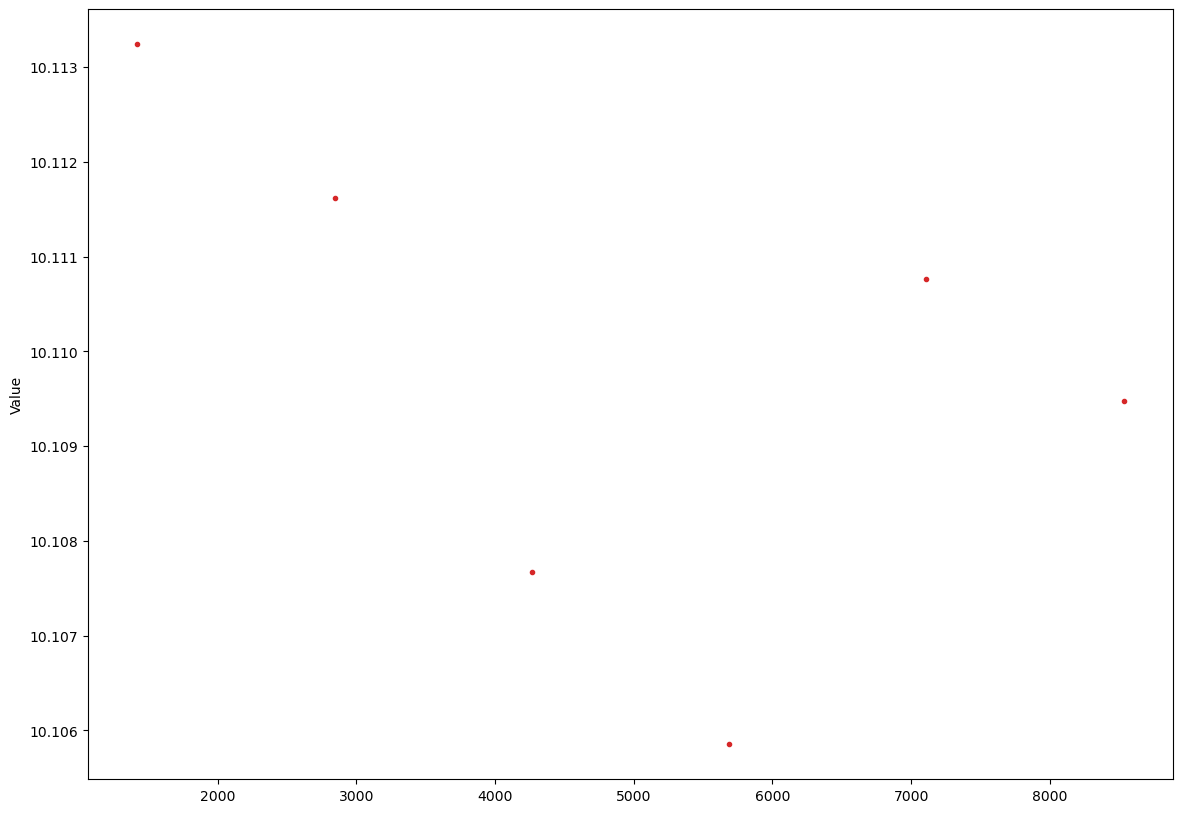

In [11]:
fig, ax1 = plt.subplots(figsize=(14,10))
ax1.set_ylabel('Value')
ax1.plot(df['num_steps'], df['Value'], 'o', markersize=3, color = 'tab:red')
plt.show()

It looks from this that the value of the product is around USD9.78, larger than the term sheet estimate of USD9.652.

Now let's see what happens as we change volatility to other reasonable levels

In [13]:

def CRRPR2_vols(S0, B, T1, T2, r1, r2, q, vol, volnum, N, Cpn, Face, tco, tcop, tac, tacp):
    """
    Function to calculates the value of a European Put Option using the CRR Binomial Model 
    
    S0: Original Stock Price
    K: Excercise Price of Call Option
    T: Time Length of Option in which to Exercise (In Years)
    r: Annualized Continously Compounded Risk-free Rate
    sigma: Annualized (Future) Volatility of Stock Price Returns
    start_step: Starting time step
    N: Number of time steps
    
    """    
    
    # LIST TO SAVE RESULTS
    crrpr2_vols = []
        
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [N+1,N+1] TO STORE ALL STEPS
    # option_value[N+1, N+1]
    option_value = np.zeros([N+1, N+1])

    # CREATE ARRAY FOR STOCK PRICES OF SIZE N+1,N+1
    # stock_value[N+1, N+1]
    stock_value = np.zeros([N+1, N+1])    
    
    # FOR LOOP STATEMENT: For a Binomial Tree from start_step to N
    for k in range(0, volnum+1):
        
        sigma = vol[k]
        
        delta = T1 / N
        u = np.exp(sigma * (delta)**0.5)
        d = 1 / u
        qu = (np.exp((r1-q) * delta) - d) / (u - d)
        qd = 1 - qu
        
        jco1 = [j/delta for j in tco]
        jco = [int(j) for j in jco1]
    
        jac1 = [j/delta for j in tac]
        jac = [int(j) for j in jac1]
        
    # CALCULATE OPTION VALUES AT CERTAIN STEPS AND POSITIONS WITHIN THE BINOMIAL TREE:
    # Start at the last step number because we are going to be moving backwards from step number n to step number 0
    # Hint: j = n and range stop = j 
        j = N
        
        for i in range(0, j+1):    
  
            stock_value[j, i] = S0 * (u**i) * (d**(j - i))
            option_value[j, i] = (Face+Cpn)*np.exp(-r2*(T2-T1))
            if stock_value[j, i] < B:
                option_value[j, i] = (Face*stock_value[j, i]/S0*np.exp(-r2*(T2-T1)))
                         
        for j in range(N-1, -1, -1):
            #if j in jco: print("coupon only",j,jco.index(j))
            #if j in jac: print("autocall",j,jac.index(j))  
            for i in range(0, j+1, 1):
                cont = np.exp(-r2 * delta) * (qu * option_value[j + 1, i + 1] + qd * option_value[j + 1, i])
                stock_value[j, i] = S0 * (u**i) * (d**(j - i))
                if j in jco: 
                    if (stock_value[j, i] >= B): cont = cont + Cpn*np.exp(-r2*(tcop[jco.index(j)]-delta*j))  
                if j in jac: 
                    if stock_value[j, i] >= B:
                        cont += Cpn*np.exp(-r2*(tacp[jac.index(j)]-delta*j))
                    if stock_value[j, i] >= S0:
                        cont = (Face + Cpn)*np.exp(-r2*(tacp[jac.index(j)]-delta*j))
                option_value[j, i] = cont    
                    
        output = {'vol': vol[k], 'Value': option_value[0,0]}
        crrpr2_vols.append(output)

    return crrpr2_vols


In [14]:
ValueV = CRRPR2_vols(S0, B, T1, T2, r1, r2, q, vol, 6, 1096*6, Cpn, Face, tco, tcop, tac, tacp)

In [15]:
df = pd.DataFrame.from_dict(ValueV)

In [16]:
df

,vol,Value
0,0.21281,9.858060
1,0.21057,9.865155
2,0.19662,9.969547
3,0.19104,10.008161
4,0.18588,10.041821
5,0.18046,10.079338
6,0.17617,10.109482


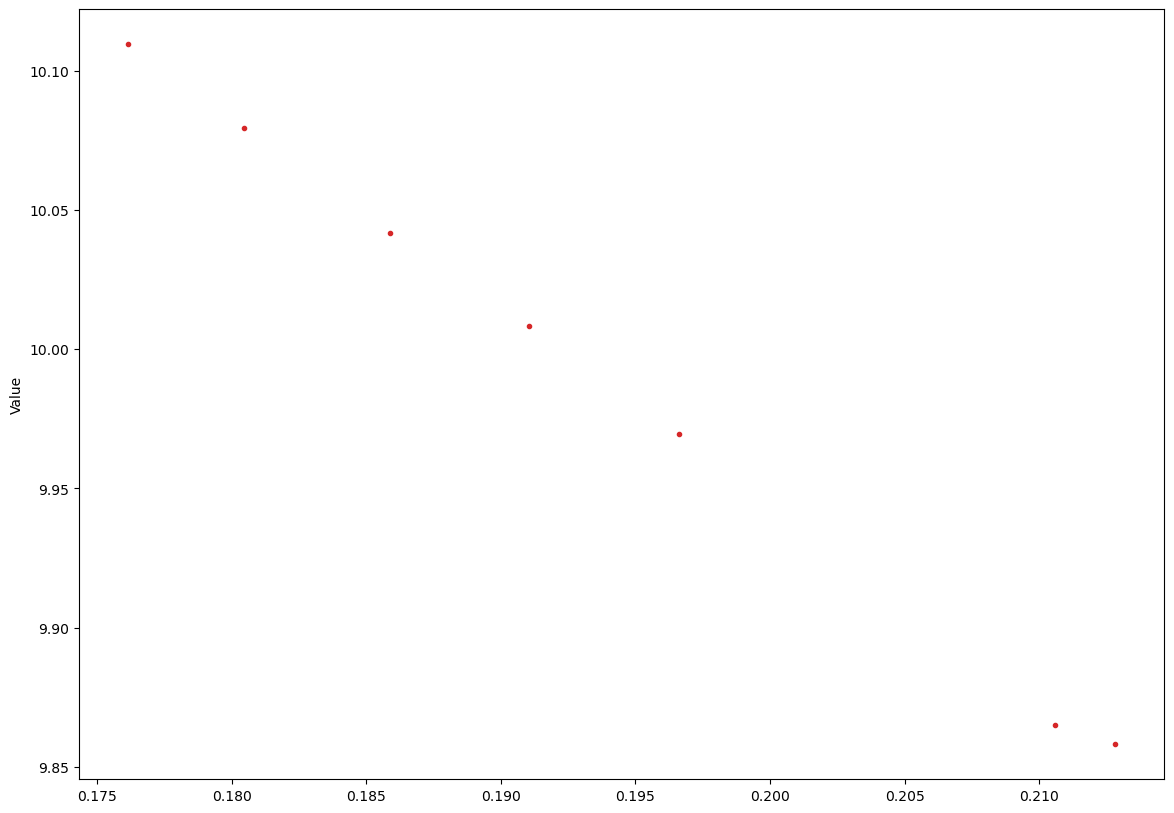

In [17]:
fig, ax1 = plt.subplots(figsize=(14,10))
ax1.set_ylabel('Value')
ax1.plot(df['vol'], df['Value'], 'o', markersize=3, color = 'tab:red')
plt.show()

We clearly see here that the effect of increasing the volatility is to reduce the value of the product as it makes it more likely that the contingent coupon will not be paid note that the prospectus value of $9.652 is very close to the values we obtain using higher of the volatility estimates.

My estimate would be in the middle of this range as the probability of hitting the autocall level (at S0) with a value of USD9.78 and the contingent coupon (at 0.5815S0) with a value of USD9.58. So, my estimate would be around USD9.68 but it is very close to the prospectus estimate.